In [2]:
import sys

In [3]:
cd '/srv/flash1/hagrawal9/project/habitat/habitat-api/'

/coc/testnvme/hagrawal9/project/habitat/habitat-api


In [4]:
import pandas as pd

In [21]:
import io
import base64
import imageio
import gzip
import json
import json_tricks
import os
import sys
import copy
from typing import Any, Dict, List, Optional, Type

import attr
import cv2
import git
import magnum as mn
import numpy as np

# %matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image

import glob
import habitat
import habitat_sim

from rearrangement.task.sensors import *

from habitat.config import Config
from habitat.core.registry import registry
from habitat_sim.utils import viz_utils as vut
from habitat.utils.visualizations import maps
from habitat.utils.visualizations.utils import observations_to_image, append_text_to_image

from habitat_sim.physics import MotionType
from habitat_sim.utils.viz_utils import is_notebook, display_video, get_fast_video_writer

In [6]:
from habitat.datasets.rearrangement.rearrangement_dataset import RearrangementDatasetV0
from habitat.tasks.rearrangement.rearrangement_task import RearrangementEpisode

In [ ]:
os.listdir('data/new_checkpoints/b9KSrZfBpB5WC5gcCUtmMX/replays/const_map_object/')
exp_list = [
    'R6dM5HQLwuD2AwkZDwG5Y6', 'TTqk2GgdMfoJHwhxp8anRV', 'K8VC8ciC2rKLPLgF7vhgyr',
    'MuZhjWcSFJdphqKMNUM9gh', 'B5X3WSUod9go46jYd6BTtq', 'HF3DSzaRxdsYWWUwdSPypu',
    'fEvzPSo8M7gxGFr2tqc6pq', 'GmnXbZH9zvtDmWzFRVpgkx', 'o9nPKX24SVJn7Dt5uNqzqy', 'SHK6CZ6SDmpVjRLhVxZBNd'
]

In [ ]:
replay_data = []
files = glob.glob('data/new_checkpoints/b9KSrZfBpB5WC5gcCUtmMX/replays/oracle_next_object/Yi8q7gpkU9V385TWwgcZbC/*')
for file in files:
    exp_uuid = file.split('/')[-2]
    # if exp_uuid in exp_list:
    with open(os.path.join(file), 'r') as f:
        data = json_tricks.load(f)
        replay_data.append(data)

In [ ]:
len(replay_data)

In [ ]:
# replay_data = []
# for i, file in enumerate(files[j:]):
#     with open(os.path.join(p, file), 'r') as f:
#         data = json_tricks.load(f)
#         replay_data.append(data)

In [ ]:
replay_df = pd.DataFrame(replay_data)

In [ ]:
replay_df['uid'] = replay_df.apply(lambda x: x['episode_id'] +'_'+ x['scene_id'], axis=1)

In [ ]:
replay_df['episode_spl'] = replay_df.apply(lambda x: x['info']['episode_spl'], axis=1)
replay_df['controller_spl'] = replay_df.apply(lambda x: x['info']['controller_spl'], axis=1)
replay_df['planner_spl'] = replay_df.apply(lambda x: x['info']['planner_spl'], axis=1)
replay_df['episode_success'] = replay_df.apply(lambda x: x['info']['episode_success'], axis=1)
replay_df['objs_success'] = replay_df.apply(lambda x: x['info']['objs_success'], axis=1)
replay_df['episode_length'] = replay_df.apply(lambda x: x['info']['episode_length'], axis=1)
replay_df['episode_mean_dist'] = replay_df.apply(lambda x: x['info']['episode_mean_dist'], axis=1)
replay_df['episode_distance'] = replay_df.apply(lambda x: x['info']['episode_distance'], axis=1)


In [ ]:
replay_df['episode_success'].mean(), replay_df['objs_success'].mean(), replay_df['episode_spl'].mean(), replay_df['planner_spl'].mean(), replay_df['controller_spl'].mean(), replay_df['episode_length'].mean(), replay_df['episode_mean_dist'].mean(), replay_df['episode_distance'].mean()

In [ ]:
replay_df.to_pickle('data/new_checkpoints/b9KSrZfBpB5WC5gcCUtmMX/replays/oracle_next_object/Yi8q7gpkU9V385TWwgcZbC.pickle')

In [ ]:
# del replay_df['actidata/new_checkpoints/b9KSrZfBpB5WC5gcCUtmMX/replays/l2dist_object/7q3NhKfhy4gW67jNeGdsfA/

In [7]:
randdf = pd.read_pickle('data/new_checkpoints/b9KSrZfBpB5WC5gcCUtmMX/replays/random_object/mQgWvVY9k28gdoSUY3cKmG.pickle')
closestdf = pd.read_pickle('data/new_checkpoints/b9KSrZfBpB5WC5gcCUtmMX/replays/closest_object/iDyuGZ6SpKrqiychD4uqGM.pickle')
l2df = pd.read_pickle('data/new_checkpoints/b9KSrZfBpB5WC5gcCUtmMX/replays/l2dist_object/7q3NhKfhy4gW67jNeGdsfA.pickle')
infmap_df = pd.read_pickle('data/new_checkpoints/b9KSrZfBpB5WC5gcCUtmMX/replays/const_map_object/6T4DVDAzwC2ZzkEtGeoerS.pickle')
ormap_df = pd.read_pickle('data/new_checkpoints/b9KSrZfBpB5WC5gcCUtmMX/replays/map_object/WWBTQggtmP6xhX6uZRDitE.pickle')
fmap_df = pd.read_pickle('data/new_checkpoints/b9KSrZfBpB5WC5gcCUtmMX/replays/oracle_next_object/Yi8q7gpkU9V385TWwgcZbC.pickle')

In [8]:
randdf['objs_success'].mean(), closestdf['objs_success'].mean(), l2df['objs_success'].mean(), infmap_df['objs_success'].mean(), ormap_df['objs_success'].mean(), fmap_df['objs_success'].mean()

(0.6137999999999999, 0.5954, 0.605, 0.623, 0.6286, 0.6732)

In [9]:
randdf.columns

Index(['episode_id', 'scene_id', 'actions', 'agent_pos',
       'sim_object_id_to_objid_mapping', 'objid_to_sim_object_id_mapping',
       'current_position', 'misc_dict', 'gripped_object_id', 'info', 'uid',
       'episode_spl', 'controller_spl', 'planner_spl', 'episode_success',
       'objs_success', 'episode_length', 'episode_mean_dist',
       'episode_distance'],
      dtype='object')

In [10]:
r = randdf['episode_length'].sem() 
c = closestdf['episode_length'].sem() 
l = l2df['episode_length'].sem() 
i = infmap_df['episode_length'].sem() 
o = ormap_df['episode_length'].sem() 
f = fmap_df['episode_length'].sem() 
print(r, c, l, i, o, f)

6.052670595062343 6.051943732962737 6.647820472608751 6.826674584736399 7.074788193223808 7.323372131701309


In [11]:
rdf = randdf[randdf['episode_spl'] > 0]
cdf = closestdf[closestdf['episode_spl'] > 0]
ldf = l2df[l2df['episode_spl'] > 0]
idf = infmap_df[infmap_df['episode_spl'] > 0]
odf = ormap_df[ormap_df['episode_spl'] > 0]

In [12]:
ruids = rdf['uid'].unique().tolist()
cuids = cdf['uid'].unique().tolist()
luids = ldf['uid'].unique().tolist()
iuids = idf['uid'].unique().tolist()
ouids = odf['uid'].unique().tolist()

In [13]:
common_uids = set(ruids).intersection(cuids).intersection(luids).intersection(iuids).intersection(ouids)

In [14]:

for uid in common_uids:
    rrow = randdf[randdf['uid']==uid].iloc[0]
    crow = closestdf[closestdf['uid']==uid].iloc[0]
    lrow = l2df[l2df['uid']==uid].iloc[0]
    irow = infmap_df[infmap_df['uid']==uid].iloc[0]
    orow = ormap_df[ormap_df['uid']==uid].iloc[0]
    # print(rrow['uid'], crow['uid'], lrow['uid'], irow['uid'], orow['uid'])
    if lrow['episode_spl'] < irow['episode_spl']:
        print(uid)
        print(crow['episode_spl'], lrow['episode_spl'], irow['episode_spl'])
        print(crow['planner_spl'], lrow['planner_spl'], irow['planner_spl'])
        print('--')

50_data/scene_datasets/gibson_train_val/Howie.glb
0.6967549034025314 0.6766763364318268 0.7820738437789271
0.7296329165512107 0.8858015526420472 0.827631338350958
--
79_data/scene_datasets/gibson_train_val/Wells.glb
0.6237337580950867 0.6190046837967287 0.7019179676599235
0.8765058684977683 0.8571007546681684 1.0
--
59_data/scene_datasets/gibson_train_val/Wells.glb
0.8555048594768212 0.6446503033675264 0.8946635032132
0.8777529910586378 0.7922626266027009 0.9248992767354574
--
54_data/scene_datasets/gibson_train_val/Spencerville.glb
0.6459793298037187 0.7715048635802328 0.7810765700433299
0.7367465524878098 0.8547491883691476 0.8701874401772491
--
27_data/scene_datasets/gibson_train_val/Sagerton.glb
0.6090886827456136 0.7425190899684763 0.9763519433581209
0.8472915452114503 0.871067167061915 0.9917092796684661
--
61_data/scene_datasets/gibson_train_val/Wells.glb
0.73994330367376 0.7747781356912669 0.9186782157175358
0.7659740214289982 0.880771121423449 0.9701745629911308
--
62_data/sce

In [15]:
eplist = ['27_data/scene_datasets/gibson_train_val/Sagerton.glb',
'8_data/scene_datasets/gibson_train_val/Cokeville.glb',
'5_data/scene_datasets/gibson_train_val/Sands.glb',
'32_data/scene_datasets/gibson_train_val/Sands.glb',
'75_data/scene_datasets/gibson_train_val/Silerton.glb',
'13_data/scene_datasets/gibson_train_val/Southfield.glb',
'52_data/scene_datasets/gibson_train_val/Southfield.glb',
'71_data/scene_datasets/gibson_train_val/Sands.glb',
'6_data/scene_datasets/gibson_train_val/Silerton.glb',
'93_data/scene_datasets/gibson_train_val/Silerton.glb',
'61_data/scene_datasets/gibson_train_val/Wells.glb']

In [16]:
for uid in eplist:
    rrow = randdf[randdf['uid']==uid].iloc[0]
    crow = closestdf[closestdf['uid']==uid].iloc[0]
    lrow = l2df[l2df['uid']==uid].iloc[0]
    irow = infmap_df[infmap_df['uid']==uid].iloc[0]
    orow = ormap_df[ormap_df['uid']==uid].iloc[0]

    print(uid)
    print(crow['episode_spl'], lrow['episode_spl'], irow['episode_spl'])
    print(crow['planner_spl'], lrow['planner_spl'], irow['planner_spl'])
    print('--')

27_data/scene_datasets/gibson_train_val/Sagerton.glb
0.6090886827456136 0.7425190899684763 0.9763519433581209
0.8472915452114503 0.871067167061915 0.9917092796684661
--
8_data/scene_datasets/gibson_train_val/Cokeville.glb
0.4218093645260496 0.6347181967512453 0.7169992610611482
0.8650634437662169 0.8893954754600716 0.9471501655208101
--
5_data/scene_datasets/gibson_train_val/Sands.glb
0.6425193319358604 0.8051001615185316 0.920432627930588
0.6711082354982533 0.8612049202004367 0.983147944554456
--
32_data/scene_datasets/gibson_train_val/Sands.glb
0.650517482020078 0.8260284833229199 0.9814255704175291
0.6558146050668586 0.8712146956499146 1.0
--
75_data/scene_datasets/gibson_train_val/Silerton.glb
0.6233862833135576 0.6762865883033872 0.8180250421424031
0.7583508421732855 0.9255706126894269 1.0
--
13_data/scene_datasets/gibson_train_val/Southfield.glb
0.641579693726637 0.7051740294282065 0.8904759252756232
0.7302360077045269 0.7863036744049767 1.0
--
52_data/scene_datasets/gibson_train

In [17]:
def depth_to_rgb(depth_image: np.ndarray, clip_max: float = 10.0) -> np.ndarray:
    """Normalize depth image into [0, 1] and convert to grayscale rgb
    :param depth_image: Raw depth observation image from sensor output.
    :param clip_max: Max depth distance for clipping and normalization.
    :return: Clipped grayscale depth image data.
    """
    d_im = np.clip(depth_image, 0, clip_max)
    d_im /= clip_max
    # d_im = np.stack([d_im for _ in range(3)], axis=2)
    rgb_d_im = (d_im * 255).astype(np.uint8)
    return rgb_d_im

In [18]:
def render_frame(obs, info):
    img_frame = Image.fromarray(obs['rgb_3rd_person'])
    rgb = Image.fromarray(obs['rgb'])
    
    if "depth" in obs:
        d_im = depth_to_rgb(obs['depth'], clip_max=1.0)[:, :, 0]
        depth_map = np.stack([d_im for _ in range(3)], axis=2)

        depth = Image.fromarray(
            depth_map
        )


    overlay_rgb_img = rgb.resize((256, 256))
    overlay_depth_img = depth.resize((256, 256))

    img_frame.paste(overlay_rgb_img, box=(32, 32))
    img_frame.paste(overlay_depth_img, box=(32, 320))
    img_frame = np.array(img_frame)
    
    top_down_map = maps.colorize_draw_agent_and_fit_to_height(
            info["top_down_map"], img_frame.shape[0]
        )
    img_frame = np.concatenate((img_frame, top_down_map), axis=1)
    return img_frame, top_down_map

In [32]:
def render_video_and_save_data(eplist, i, df, dftype):
    uid = eplist[i]
    eid = eplist[i].split('_')[0]
    scene_id = eplist[i][len(eid) + 1:]
    print(eid, scene_id)
    
    data = df[df['uid'] == uid].iloc[0].to_dict()
    
    config = habitat.get_config("configs/tasks/rearrangement_gibson_map.yaml")
    
    config.defrost()
    config.DATASET.SPLIT = "test"
    config.DATASET.CONTENT_SCENES = [f"rearrangement_hard_v8_{config.DATASET.SPLIT}_n=100_o=5_t=0.9_{scene_id.split('/')[-1].split('.')[0]}"]
    config.TASK.MEASUREMENTS = ['OBJECT_TO_GOAL_DISTANCE', 'AGENT_TO_OBJECT_DISTANCE', 'EOR_TOP_DOWN_MAP']
    # config.TASK.SENSORS = ['GRIPPED_OBJECT_SENSOR', 'ALL_OBJECT_POSITIONS', 'ALL_OBJECT_GOALS', 'ORACLE_NEXT_OBJECT_SENSOR',]
    # config.defrost()
    config.SIMULATOR.DEPTH_SENSOR.HEIGHT = 1024
    config.SIMULATOR.DEPTH_SENSOR.WIDTH = 1024
    config.SIMULATOR.RGB_SENSOR.HEIGHT = 1024
    config.SIMULATOR.RGB_SENSOR.WIDTH = 1024
    config.SIMULATOR.CROSSHAIR_POS = [512, 768]
    config.SIMULATOR.RGB_SENSOR_3RD_PERSON.HEIGHT = 1024
    config.SIMULATOR.RGB_SENSOR_3RD_PERSON.WIDTH = 1820
    config.TASK.EOR_TOP_DOWN_MAP.MAX_RESOLUTION = 1024
    config.TASK.EOR_TOP_DOWN_MAP.MAX_RESOLUTION = 1024
    # config.freeze()
    config.freeze()
    
    try:
        env.close()
    except:
        pass
    env = habitat.Env(config)
    
    # go to the desired episode
    for ep in env.episodes:
        if ep.episode_id == eid:
            break
    
    env._current_episode = ep
    env._reset_stats()

    if env._current_episode is not None:
        env._current_episode._shortest_path_cache = None
    
    env.reconfigure(env._config)
    obs = env.task.reset(episode=env.current_episode)
    env._task.measurements.reset_measures(
        episode=env.current_episode, task=env.task
    )
    metrics = env.get_metrics()
    
    plt.imshow(obs['rgb_3rd_person'])
    plt.show()
    
    top_down_map = maps.get_topdown_map(
        env._task._simple_pathfinder,
        env._sim.get_agent(0).state.position[1],
        1024
    )

    top_down_map = maps.colorize_topdown_map(top_down_map)
    agent_position = env._sim.get_agent_state().position
    a_x, a_y = maps.to_grid(
        agent_position[2],
        agent_position[0],
        top_down_map.shape[0:2],
        sim=env._sim,
    )

    episode = env.current_episode
    object_positions = [obj.position for obj in episode.objects]
    goal_positions = [obj.position for obj in episode.goals]

    grid_object_positions = []
    grid_goal_positions = []

    for i, obj_pos in enumerate(object_positions):
        tdm_pos = maps.to_grid(
            obj_pos[2],
            obj_pos[0],
            top_down_map.shape[0:2],
            sim=env._sim,
        )
        grid_object_positions.append(tdm_pos)

    # draw the objectgoal positions.
    for i, goal_pos in enumerate(goal_positions):
        tdm_pos = maps.to_grid(
            goal_pos[2],
            goal_pos[0],
            top_down_map.shape[0:2],
            sim=env._sim,
        )

        grid_goal_positions.append(tdm_pos)

    grid_current_positions = [None] * len(object_positions)
    for sim_obj_id in env._sim.get_existing_object_ids():
        if sim_obj_id != env._task.agent_object_id:
            obj_id = env._task.sim_object_to_objid_mapping[sim_obj_id]
            position = env._sim.get_translation(sim_obj_id)
            curr_pos = maps.to_grid(position[2], position[0], top_down_map.shape[0:2], sim=env._sim)
            grid_current_positions[obj_id] = curr_pos


    top_down_map = maps.draw_agent(
        image=top_down_map,
        agent_center_coord=[a_x, a_y],
        agent_rotation=0,
        agent_radius_px=min(top_down_map.shape[0:2]) / 32,
    )

    top_down_map = maps.draw_object_info(top_down_map, grid_goal_positions, suffix='g')
    top_down_map = maps.draw_object_info(top_down_map, grid_current_positions, suffix='c')

    plt.imshow(top_down_map)
    plt.show()
    
    frames = []
    metric_list = []
    obs_list = []
    constructed_map = []
    top_down_map_frames = []

    final_pos = []
    prev_len = 5
    for action in data['actions']:
        obs = env.step(action['action'])
        metrics = env.get_metrics()
        # print(metrics['top_down_map']['map'].shape)
        # info = env.get_info(obs)
        # return env, obs, metrics
        img_frame, top_down_map = render_frame(obs, metrics)
        po = env.task.misc_dict['pickup_order_const_map_object'] + 1
        opo = data['misc_dict']['pickup_order_oracle_next_object'] + 1
        
        if len(po) < prev_len:
            for o, d in metrics['object_to_goal_distance'].items():
                if d <= 0.25 and (o+1) not in final_pos:
                    final_pos.append(o+1)
                    prev_len = len(po)
                    break
                    
        dpo = final_pos + po.tolist()
                
        img_frame = append_text_to_image(
            img_frame, 
            text="PLASMA Pickup Order = {}\nOracle Pickup Order: {}\n Episode SPL: {:.2f}".format(
                dpo, data['misc_dict']['pickup_order_oracle_next_object'], data['episode_spl']
            )
        )
            
        frames.append(img_frame)
        top_down_map_frames.append(top_down_map)
        obs_list.append(obs)
        constructed_map.append(copy.deepcopy(env._task.misc_dict['obstacles_mask']))
        metric_list.append(metrics)

        print(f"\r {len(frames)}, {len(data['actions'])}", end=" ")
        
        # return env, obs, metrics, img_frame, top_down_map

    #     plt.imshow(obs['rgb_3rd_person'])
    #     plt.title(action)
    #     plt.show()
    
    env.close()
    
    return constructed_map

    name = eid + '_' + scene_id.split('/')[-1].split('.')[0] + '_' + dftype + '.mp4'
    
    
    result_data = {
        'name': eid + '_' + scene_id.split('/')[-1].split('.')[0] + '_' + dftype,
        'frames': frames, 
        'metric_list': metric_list, 
        'obs_list': obs_list, 
        'top_down_map_frames': top_down_map_frames
    }
    
    
    map_name = 'debug_' + eid + '_' + scene_id.split('/')[-1].split('.')[0]
    dir_path = os.path.join('data/map_visualizations/', dftype, map_name)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    
    for i, tdmframe in enumerate(top_down_map_frames):
        im = Image.fromarray(tdmframe)
        im.save(dir_path + '/' + str(i) + '.png')
    
    writer = get_fast_video_writer('data/supp_videos/' + name, fps=10)
    
    
    for image_frame in frames:
        writer.append_data(np.array(image_frame))
    #    plt.figure(figsize=(5,10), dpi=300)
    #     plt.imshow()
    #     plt.savefig(name[:-4] + '.jpg'

    writer.close()
    
    print(name)
    
    return result_data

In [ ]:
result_data = render_video_and_save_data(eplist, 0, l2df, 'l2df')

2020-11-23 21:47:36,774 Initializing dataset RearrangementDataset-v0
2020-11-23 21:47:36,793 initializing sim RearrangementSim-v0


8 data/scene_datasets/gibson_train_val/Cokeville.glb
Episode Length: 0
Episode Length: 100


I1123 21:47:40.483415 40674 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Cokeville.navmesh
I1123 21:47:40.485290 40674 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.
2020-11-23 21:47:40,673 Initializing task RearrangementTask-v0


GPU_ID: 0


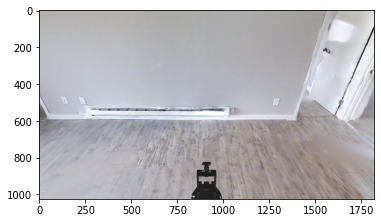

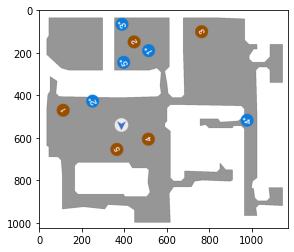

 393, 471 

In [ ]:
result_data = render_video_and_save_data(eplist, 1, infmap_df, 'inf')

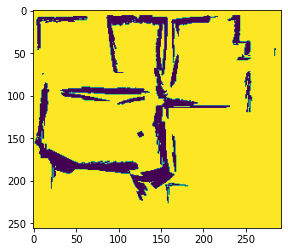

In [54]:
plt.imshow(result_data[250])

In [ ]:
m['object_to_goal_distance']

In [ ]:
e.close()

In [ ]:
i = 0
uid = eplist[i]
eid = eplist[i].split('_')[0]
scene_id = eplist[i][len(eid) + 1:]
print(eid, scene_id)

data = l2df[l2df['uid'] == uid].iloc[0].to_dict()


In [ ]:
data['misc_dict']['pickup_order_oracle_next_object']

In [ ]:
for i in range(len(eplist)):
    # result_data = render_video_and_save_data(eplist, i, randdf, 'rand')
    # result_data = render_video_and_save_data(eplist, i, l2df, 'l2')
    # result_data = render_video_and_save_data(eplist, i, closestdf, 'closest')
    result_data = render_video_and_save_data(eplist, i, infmap_df, 'infmap')
    
    uid = eplist[i]
    
    rrow = randdf[randdf['uid']==uid].iloc[0]
    crow = closestdf[closestdf['uid']==uid].iloc[0]
    lrow = l2df[l2df['uid']==uid].iloc[0]
    irow = infmap_df[infmap_df['uid']==uid].iloc[0]
    orow = ormap_df[ormap_df['uid']==uid].iloc[0]

    print(uid)
    print(crow['episode_spl'], lrow['episode_spl'], irow['episode_spl'])
    print(crow['planner_spl'], lrow['planner_spl'], irow['planner_spl'])
    print('--')

In [ ]:
display_video('data/5_Sands_rand.mp4')

In [ ]:
def restore_state(replay, env):
    for sim_obj_id, obj_id in replay['sim_object_id_to_objid_mapping'].items(): 
        curr_sim_obj_id = env._task.objid_to_sim_object_mapping[obj_id]
        env._sim.set_object_motion_type(
            MotionType.KINEMATIC, curr_sim_obj_id
        )
        env._sim.set_translation(replay['current_position'][sim_obj_id], curr_sim_obj_id)
        env._sim.set_object_motion_type(
            MotionType.STATIC, curr_sim_obj_id
        )
        agent_cfg = env._sim._get_agent_config(0)
        env._sim.set_agent_state(
            replay['agent_pos'],
            agent_cfg.START_ROTATION,
            0,
        )
        env._sim.set_translation(replay['agent_pos'], env._task.agent_object_id)
        

        print(sim_obj_id, obj_id, curr_sim_obj_id)
    env._task.measurements.update_measures(
        episode=env.current_episode, action=0, task=env.task
    )

In [ ]:
# for obj_id, goal in enumerate(env.current_episode.goals):

#     agent_state = env._sim.get_agent_state()
#     agent_position = agent_state.position
#     sim_obj_id = env._task.objid_to_sim_object_mapping[obj_id]
#     previous_position = np.array(
#         env._sim.get_translation(sim_obj_id)
#     ).tolist()

#     goal_position = env.current_episode.goals[obj_id].position
#     previous_position[1] = agent_position[1]
 
#     d = geodesic_distance(
#         env._sim.pathfinder, previous_position, agent_position
#     )
#     print(obj_id, d)

In [ ]:
result_data = {
    'frames': frames, 
    'metric_list': metric_list, 
    'obs_list': obs_list, 
}

In [ ]:
with open('data/'+ name + '.json', 'w') as f:
    json_tricks.dump(result_data, f)